# Contrastive predictive coding - work in progress

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import torch.optim as optim
import h5py
import os
import random

torch.cuda.is_available()

In [52]:
torch.cuda.is_available()

True

## key idea

$X = [x_1, x_2, ..., x_n]$ is a vector of $N$ samples containing $1$ positive sample from $p(x_{t+k}|c_t)$ and $N-1$ negative samples drawn from the distribution $p(x_{t+k})$. These are the other samples in the batch at the same timestep $k$.

Each batch $X$ is of size $N * channel * seq$. We select one random time point between 0 and sequence len to be $t=0$. We use the same t for each sample $n$ in the batch.

Now, for each sample $n$ we need to compute:  
- the past context $c_t$
- the future encoded time steps $z_{t+1},z_{t+2},...,z_{t+k}$  

we will then teach the network to classify for each time step $k$, what is the correct $z_{t+k}$ among the $N$ samples within the batch, given the context $c_t$

$c_t$ for each $n$ is given by first encoding at once the whole batch $X$ until $t=0$, that is  $z_{t-k:t}=g_{enc}(X_{t-k:t})$. This returns a tensor of size $N * channel * seq$.  
Second we reshape $z_{t-k:t}$ to $N * seq * channel$ and pass it to $g_{ar}$, so that $c_t = g_{ar}(z_{t-k:t})$. This returns a tensor of shape $??$ (check what GRU returns)

$f_k(x_{t+k},c_t) = exp(z^T_{t+k} W_k c_t)$

For example, for a batch of N samples at time $t+k$ the correct output of $f_k(x_{t+k},c_t)$ is the identity matrix of size $NxN$.

\begin{bmatrix}
1,0,0,0 \\
0,1,0,0 \\
0,0,1,0 \\
0,0,0,1 
\end{bmatrix}



dataset: LibriSpeech - train-clean-100.tar.gz|

http://www.openslr.org/12/




## CPC architecture

In [3]:
class CPC(nn.Module):

    def __init__(self, n_timesteps, n_samples, seq_len):
        
        super(CPC, self).__init__()
        
        self.n_timesteps = n_timesteps
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.comp_rate = 160

        self.g_enc = nn.Sequential(
            
                        nn.Conv1d(1, 512, stride=5, kernel_size=10, padding=3, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=4, kernel_size=8, padding=2, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True)

                         )

        # autoregressive unit
        self.g_ar = nn.GRU(512, 256, batch_first=True)

        # list of W for each k timestep
        # note the input=256 from the GRU, output=512 to match the size of z
        self.W = nn.ModuleList([nn.Linear(256,512) for t in range(self.n_timesteps)])

        # softmax function to compute the prediction
        self.softmax = nn.Softmax(dim=0)

        # log softmax function to compute final loss
        self.log_softmax = nn.LogSoftmax(dim=0)


        def weights_initialization(module):

            if type(module) == nn.Conv1d:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.GRU:
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')


        self.apply(weights_initialization)



    # hidden state initialization with zeros for first gru loop
    def initialize_hidden(self, gpu=True): # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        if gpu:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).cuda()
            # hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).to(device)
        else:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size)
            
        return hidden
    
    
    def forward(self, X, hidden, device):
        
        # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        z = self.g_enc(X)
        z = z.transpose(1,2)

        t = torch.randint(1, self.seq_len // self.comp_rate - self.n_timesteps, size=(1,))
#         print('random time sample: ',t)
        
        c_t = z[:,:t,:]
        c_t, hidden = self.g_ar(c_t)
        c_t = c_t[:,t-1,:].view(self.n_samples, 256)

        loss = 0
        acc = []

        for k in range(n_timesteps):

            w_k = self.W[k]
            y_k = w_k(c_t)

            z_k = z[:,t+k,:].view(self.n_samples,512)      

            f_k = torch.mm(z_k, y_k.transpose(0,1))
            
            # compute loss
            loss_k = self.log_softmax(f_k)
            loss_k = torch.diagonal(loss_k)
            loss_k = torch.sum(loss_k)

            loss += loss_k
            
            # compute correct output
            pred_k = self.softmax(f_k)
            pred_k = torch.argmax(pred_k, dim=0)
            
            gt_k = torch.arange(0, self.n_samples, device=device)
            
            corr_k = torch.eq(pred_k,gt_k)
            corr_k = torch.sum(corr_k)
            acc_k = corr_k.item()/self.n_samples
            
            acc.append(acc_k)
            

        loss *= -1
        loss /= self.n_samples*self.n_timesteps
        

        return loss, acc, hidden
    
    
    def predict(self, X, hidden):
        
        z = self.g_enc(X)
        z = z.transpose(1,2)
        c_t, hidden = self.g_ar(z)
        
        return c_t[:,-1,:], hidden

## Librispeech Dataset functions

In [4]:
class LibriSpeech100_dataset(Dataset):
    
    def __init__(self, data_path, seq_len, batch_size):
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.data = h5py.File(data_path, 'r')
        self.file_list = list(self.data.keys())
        self.file_list = self.file_list[:(len(self.file_list)//batch_size)*batch_size]
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        filename = self.file_list[idx]
        audio_file = self.data[filename][()]
        rnd_idx = np.random.randint(0, len(audio_file)-self.seq_len)
        audio_sample = audio_file[rnd_idx:rnd_idx+self.seq_len]
        audio_sample = audio_sample.reshape(1,-1)
        
        return audio_sample
    
    
def LibriSpeech100_preprocessing(file_list_path, data_path, output_path, seq_len):

    file_list = open(file_list_path).read().split('\n')[:100]
    dset_formatted = h5py.File(output_path, 'w')
    
    for filename in file_list:
#         print(filename)
        reader_id, chapter_id, _ = filename.split('-') 
        file_path = os.path.join(data_path,reader_id,chapter_id,filename)+'.flac'
#         print(file_path)
        audio_file, sr = sf.read(file_path)
        if audio_file.shape[0]>seq_len:
            dset_formatted.create_dataset(filename, data=audio_file)

    dset_formatted.close()

## train and validation functions

In [19]:
def train(model, optimizer, train_dataloader, device):

    model.train()
    total_train_loss = 0
    total_train_acc = []

    for idx_batch, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        hidden = model.initialize_hidden(gpu=gpu)
        loss, acc, hidden = model.forward(batch.float().to(device), hidden, device)

        loss.backward()
        optimizer.step()
        
        total_train_loss += len(batch) * loss
        total_train_acc.append(acc)

    total_train_loss /= len(train_dataloader.dataset)

    return total_train_loss, total_train_acc


def validation(model, valid_dataloader, device):

    model.eval()
    total_val_loss = 0
    total_val_acc = []


    with torch.no_grad():
        for idx_batch, batch in enumerate(valid_dataloader):
    #             print(batch.size())
            hidden = model.initialize_hidden(gpu=gpu)
            val_loss, val_acc, hidden = model.forward(batch.float().to(device), hidden, device=device)
            total_val_loss += len(batch) * val_loss
            total_val_acc.append(val_acc)


    total_val_loss /= len(valid_dataloader.dataset)
    
    return total_val_loss, total_val_acc

## data preprocessing

### custom train valid split

In [6]:
base_path = "/home/giovanni/Documents/contrastive_predictive_coding/cpc_libri_speech/data/"
file_list_train_path = base_path+'LibriSpeech100_labels_split/train_split.txt'

file_list = open(file_list_train_path).read().split('\n')
random.shuffle(file_list)

split_idx = int(len(file_list)*0.8)

train_set = file_list[:split_idx]
valid_set = file_list[split_idx:]

with open(base_path+'labels_split/train_split.txt', 'w') as f:
    f.write('\n'.join(train_set))
f.close()

with open(base_path+'labels_split/valid_split.txt', 'w') as f:
    f.write('\n'.join(valid_set))
f.close()

### preprocess and store dataset

In [19]:
data_path = '/Users/yc00088/Documents/Affective_computing/datasets/libri_speech/LibriSpeech/train-clean-100'
seq_len = 20480

train_file_list_path = 'data/labels_split/train_split.txt'
valid_file_list_path = 'data/labels_split/valid_split.txt'
test_file_list_path  = 'data/labels_split/test_split.txt'

train_output_path = 'data/processed_new/librispeech_train.hdf5'
valid_output_path = 'data/processed_new/librispeech_valid.hdf5'
test_output_path  = 'data/processed_new/librispeech_test.hdf5'

LibriSpeech100_preprocessing(train_file_list_path, data_path, train_output_path, seq_len)
LibriSpeech100_preprocessing(valid_file_list_path, data_path, valid_output_path, seq_len)
LibriSpeech100_preprocessing(test_file_list_path, data_path, test_output_path, seq_len)

## model and dataset initialization

In [7]:
gpu = True
seq_len = 20480
comp_rate = 160
n_timesteps = 12
n_samples = 8

In [9]:
torch.cuda.is_available()

True

In [10]:
train_data_path = base_path+'processed_new/librispeech_train.hdf5'
valid_data_path = base_path+'processed_new/librispeech_valid.hdf5'
test_data_path  = base_path+'processed_new/librispeech_test.hdf5'

libri_train = LibriSpeech100_dataset(train_data_path,seq_len,n_samples)
libri_valid = LibriSpeech100_dataset(valid_data_path,seq_len,n_samples)
libri_test = LibriSpeech100_dataset(test_data_path,seq_len,n_samples)

In [11]:
train_dataloader = DataLoader(libri_train, batch_size=n_samples, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(libri_valid, batch_size=n_samples, shuffle=True, num_workers=0)
test_dataloader = DataLoader(libri_test, batch_size=n_samples, shuffle=True, num_workers=0)

In [12]:
device_type = 'cpu'

if gpu:
    device_type = 'cuda'

device = torch.device(device_type)

In [13]:
device = torch.device('cuda:0')

In [14]:
cpc_test = CPC(n_timesteps, n_samples, seq_len).to(device)

In [15]:
train_params = [p for p in cpc_test.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params)

In [17]:
#cpc_test.to(device)

## training

-- epoch 0 --
train loss: 0.8695163130760193
valid loss: 0.8353641033172607


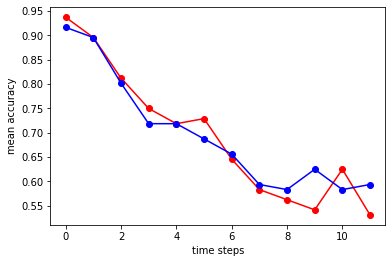

-- epoch 1 --
train loss: 0.8754695653915405
valid loss: 1.0694732666015625
-- epoch 2 --
train loss: 0.8553366661071777
valid loss: 0.9275679588317871
-- epoch 3 --
train loss: 0.7789868712425232
valid loss: 0.9205400943756104
-- epoch 4 --
train loss: 0.7573615908622742
valid loss: 0.8753780126571655
-- epoch 5 --
train loss: 0.835059404373169
valid loss: 0.7656372785568237
-- epoch 6 --
train loss: 0.7868759632110596
valid loss: 0.8653833270072937
-- epoch 7 --
train loss: 0.913794994354248
valid loss: 0.9526437520980835
-- epoch 8 --
train loss: 0.801548957824707
valid loss: 0.8577877283096313
-- epoch 9 --
train loss: 0.8385658264160156
valid loss: 0.9838184714317322
-- epoch 10 --
train loss: 0.7465585470199585
valid loss: 1.0447466373443604


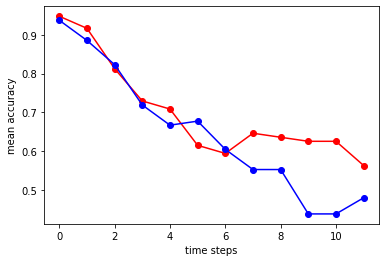

-- epoch 11 --
train loss: 0.7685362100601196
valid loss: 0.8276282548904419
-- epoch 12 --
train loss: 0.8092242479324341
valid loss: 0.9120780229568481
-- epoch 13 --
train loss: 0.9635393619537354
valid loss: 0.9050104022026062
-- epoch 14 --
train loss: 0.8408891558647156
valid loss: 0.733086109161377
-- epoch 15 --
train loss: 0.77476567029953
valid loss: 1.053859829902649
-- epoch 16 --
train loss: 0.7347389459609985
valid loss: 0.9819139838218689
-- epoch 17 --
train loss: 0.7539900541305542
valid loss: 0.9976708292961121
-- epoch 18 --
train loss: 0.8548499345779419
valid loss: 0.7961680889129639
-- epoch 19 --
train loss: 0.6894859075546265
valid loss: 0.8308612704277039
-- epoch 20 --
train loss: 0.7442188262939453
valid loss: 0.841098427772522


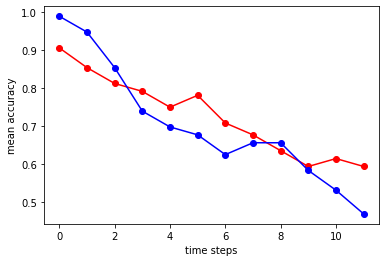

-- epoch 21 --
train loss: 0.8507689833641052
valid loss: 0.8153581619262695
-- epoch 22 --
train loss: 0.8508107662200928
valid loss: 0.9030702114105225
-- epoch 23 --
train loss: 0.787165641784668
valid loss: 0.855028510093689
-- epoch 24 --
train loss: 0.7432734370231628
valid loss: 0.807724118232727
-- epoch 25 --
train loss: 0.8185427188873291
valid loss: 0.7791284918785095
-- epoch 26 --
train loss: 0.8276380896568298
valid loss: 0.8369187712669373
-- epoch 27 --
train loss: 0.7210186719894409
valid loss: 0.9456011652946472
-- epoch 28 --
train loss: 0.8051795959472656
valid loss: 0.8115671873092651
-- epoch 29 --
train loss: 0.9288684725761414
valid loss: 0.8445690870285034
-- epoch 30 --
train loss: 0.8219639658927917
valid loss: 0.8986636400222778


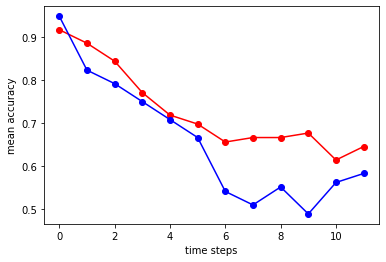

-- epoch 31 --
train loss: 0.8017527461051941
valid loss: 0.8245311975479126
-- epoch 32 --
train loss: 0.8130632638931274
valid loss: 0.9055951833724976
-- epoch 33 --
train loss: 0.930550217628479
valid loss: 0.9110351800918579
-- epoch 34 --
train loss: 0.825343132019043
valid loss: 0.8692652583122253
-- epoch 35 --
train loss: 0.8319639563560486
valid loss: 0.8033108711242676
-- epoch 36 --
train loss: 0.9236041903495789
valid loss: 0.8575112819671631
-- epoch 37 --
train loss: 0.8570339679718018
valid loss: 0.7652267217636108
-- epoch 38 --
train loss: 0.7866250276565552
valid loss: 0.8375033736228943
-- epoch 39 --
train loss: 1.0319035053253174
valid loss: 0.9385894536972046
-- epoch 40 --
train loss: 0.8747276663780212
valid loss: 0.7921169996261597


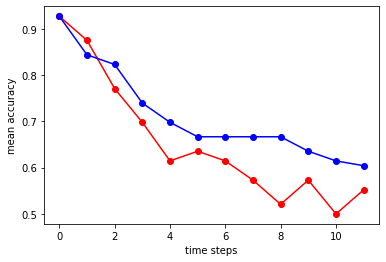

-- epoch 41 --
train loss: 0.7778605222702026
valid loss: 0.764349639415741
-- epoch 42 --
train loss: 0.7460994720458984
valid loss: 0.717570424079895
-- epoch 43 --
train loss: 0.6987170577049255
valid loss: 0.7276291251182556
-- epoch 44 --
train loss: 0.7585751414299011
valid loss: 0.851618766784668
-- epoch 45 --
train loss: 0.8706678748130798
valid loss: 0.9877791404724121
-- epoch 46 --
train loss: 0.8199869990348816
valid loss: 0.8460983633995056
-- epoch 47 --
train loss: 0.7905107736587524
valid loss: 0.8734065890312195
-- epoch 48 --
train loss: 0.7546558380126953
valid loss: 0.9666026830673218
-- epoch 49 --
train loss: 1.0501891374588013
valid loss: 0.9396016001701355
-- epoch 50 --
train loss: 0.7629682421684265
valid loss: 0.8652498126029968


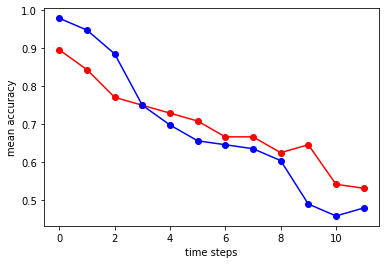

-- epoch 51 --
train loss: 0.8137257099151611
valid loss: 0.7921563386917114
-- epoch 52 --
train loss: 0.7613288164138794
valid loss: 0.7816569209098816
-- epoch 53 --
train loss: 0.8112679719924927
valid loss: 0.843662440776825
-- epoch 54 --
train loss: 0.7289707064628601
valid loss: 0.8526381850242615
-- epoch 55 --
train loss: 0.7062453031539917
valid loss: 0.8907262682914734
-- epoch 56 --
train loss: 0.8376898765563965
valid loss: 0.8267157077789307
-- epoch 57 --
train loss: 0.8681644201278687
valid loss: 0.817415714263916
-- epoch 58 --
train loss: 0.8364418745040894
valid loss: 0.9060678482055664
-- epoch 59 --
train loss: 0.8511139750480652
valid loss: 0.8646550178527832
-- epoch 60 --
train loss: 0.9012426137924194
valid loss: 0.8920056819915771


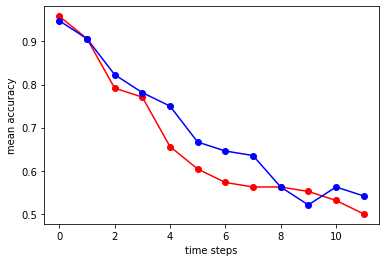

-- epoch 61 --
train loss: 0.8460133075714111
valid loss: 0.794134795665741
-- epoch 62 --
train loss: 0.829899251461029
valid loss: 0.9525701403617859
-- epoch 63 --
train loss: 0.7721280455589294
valid loss: 0.8311917781829834
-- epoch 64 --
train loss: 0.8850905299186707
valid loss: 0.928226113319397
-- epoch 65 --
train loss: 0.7688536047935486
valid loss: 0.6913465261459351
-- epoch 66 --
train loss: 0.8191195726394653
valid loss: 0.8368312120437622
-- epoch 67 --
train loss: 0.7856754064559937
valid loss: 0.9274064302444458
-- epoch 68 --
train loss: 0.6980031728744507
valid loss: 0.8022536039352417
-- epoch 69 --
train loss: 0.7568938732147217
valid loss: 0.8959810137748718
-- epoch 70 --
train loss: 0.7039434313774109
valid loss: 0.8820239901542664


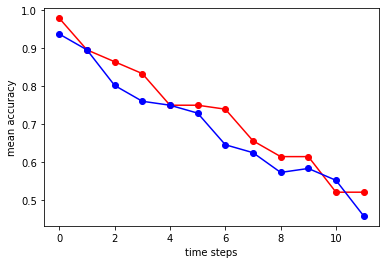

-- epoch 71 --
train loss: 0.8550039529800415
valid loss: 0.7598662376403809
-- epoch 72 --
train loss: 0.843026876449585
valid loss: 0.7789624929428101
-- epoch 73 --
train loss: 0.7071535587310791
valid loss: 0.8350879549980164
-- epoch 74 --
train loss: 0.7755386233329773
valid loss: 0.9772073030471802
-- epoch 75 --
train loss: 0.7460658550262451
valid loss: 0.7794238328933716
-- epoch 76 --
train loss: 0.8651913404464722
valid loss: 0.945128858089447
-- epoch 77 --
train loss: 0.9035682082176208
valid loss: 0.7510117888450623
-- epoch 78 --
train loss: 0.7991778254508972
valid loss: 0.9126390814781189
-- epoch 79 --
train loss: 0.7802046537399292
valid loss: 0.8299267292022705
-- epoch 80 --
train loss: 0.7449774742126465
valid loss: 0.9289780855178833


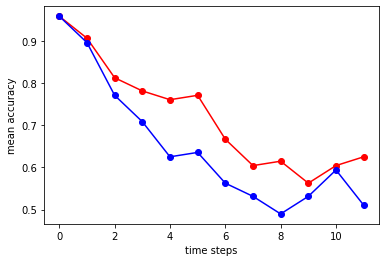

-- epoch 81 --
train loss: 0.8443538546562195
valid loss: 0.7923153638839722
-- epoch 82 --
train loss: 0.791616678237915
valid loss: 0.9474058151245117
-- epoch 83 --
train loss: 0.83042311668396
valid loss: 0.8066136240959167
-- epoch 84 --
train loss: 0.8790680170059204
valid loss: 0.7304598689079285
-- epoch 85 --
train loss: 0.8087592124938965
valid loss: 0.7602274417877197
-- epoch 86 --
train loss: 0.8510884046554565
valid loss: 0.945480227470398
-- epoch 87 --
train loss: 0.7728473544120789
valid loss: 0.8306304216384888
-- epoch 88 --
train loss: 0.855932891368866
valid loss: 0.7744674682617188
-- epoch 89 --
train loss: 0.8395389318466187
valid loss: 0.7523927092552185
-- epoch 90 --
train loss: 0.721399188041687
valid loss: 0.8982364535331726


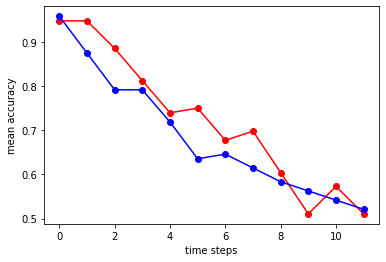

-- epoch 91 --
train loss: 0.7704378366470337
valid loss: 0.8400068283081055
-- epoch 92 --
train loss: 0.6924682855606079
valid loss: 0.9493335485458374
-- epoch 93 --
train loss: 0.7178406715393066
valid loss: 0.7272986769676208
-- epoch 94 --
train loss: 0.7574949264526367
valid loss: 0.6661251187324524
-- epoch 95 --
train loss: 0.7603816986083984
valid loss: 0.841803789138794
-- epoch 96 --
train loss: 0.8549246788024902
valid loss: 0.9819161891937256
-- epoch 97 --
train loss: 0.8398240804672241
valid loss: 0.9361781477928162
-- epoch 98 --
train loss: 0.8184839487075806
valid loss: 0.831277072429657
-- epoch 99 --
train loss: 0.8950849771499634
valid loss: 0.8392388820648193
-- epoch 100 --
train loss: 0.6757060885429382
valid loss: 0.834063708782196


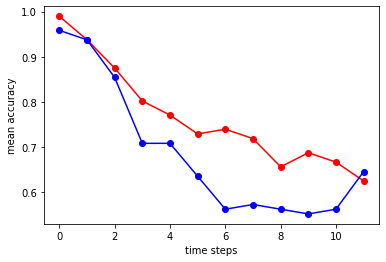

-- epoch 101 --
train loss: 0.8424572944641113
valid loss: 0.8514553308486938
-- epoch 102 --
train loss: 0.7530710101127625
valid loss: 0.9877092242240906
-- epoch 103 --
train loss: 0.8984078764915466
valid loss: 0.8246699571609497
-- epoch 104 --
train loss: 0.8674184679985046
valid loss: 0.8652693629264832
-- epoch 105 --
train loss: 0.7522016763687134
valid loss: 0.8322755098342896
-- epoch 106 --
train loss: 0.6558170318603516
valid loss: 0.7717610597610474
-- epoch 107 --
train loss: 0.8218128085136414
valid loss: 0.8824002146720886
-- epoch 108 --
train loss: 0.8033394813537598
valid loss: 0.8476955890655518
-- epoch 109 --
train loss: 0.7933589220046997
valid loss: 0.7930780649185181
-- epoch 110 --
train loss: 0.7728115916252136
valid loss: 0.7597317099571228


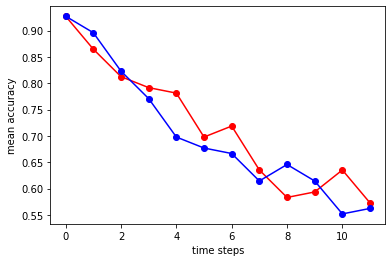

-- epoch 111 --
train loss: 0.7532169818878174
valid loss: 0.8973432779312134
-- epoch 112 --
train loss: 0.7029914259910583
valid loss: 0.7357596158981323
-- epoch 113 --
train loss: 0.7510406374931335
valid loss: 0.8290677070617676
-- epoch 114 --
train loss: 0.7584556341171265
valid loss: 0.6456853151321411
-- epoch 115 --
train loss: 0.7335391044616699
valid loss: 0.794094979763031
-- epoch 116 --
train loss: 0.665278434753418
valid loss: 0.8226474523544312
-- epoch 117 --
train loss: 0.7506775856018066
valid loss: 0.7025267481803894
-- epoch 118 --
train loss: 0.760858416557312
valid loss: 0.7254151105880737
-- epoch 119 --
train loss: 0.671730637550354
valid loss: 0.9544727206230164
-- epoch 120 --
train loss: 0.7027409076690674
valid loss: 0.851553201675415


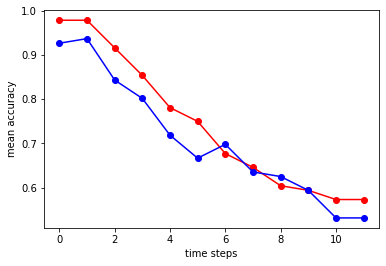

-- epoch 121 --
train loss: 0.7021817564964294
valid loss: 0.932532548904419
-- epoch 122 --
train loss: 0.8220183253288269
valid loss: 0.8778402805328369
-- epoch 123 --
train loss: 0.5902843475341797
valid loss: 0.5925362706184387
-- epoch 124 --
train loss: 0.7097245454788208
valid loss: 0.8094083070755005
-- epoch 125 --
train loss: 0.8131301403045654
valid loss: 0.6994993686676025
-- epoch 126 --
train loss: 0.693779706954956
valid loss: 0.7330881953239441
-- epoch 127 --
train loss: 0.7098945379257202
valid loss: 0.8068684339523315
-- epoch 128 --
train loss: 0.736602783203125
valid loss: 0.7568368315696716
-- epoch 129 --
train loss: 0.7461748123168945
valid loss: 0.585629940032959
-- epoch 130 --
train loss: 0.7808467745780945
valid loss: 0.8778040409088135


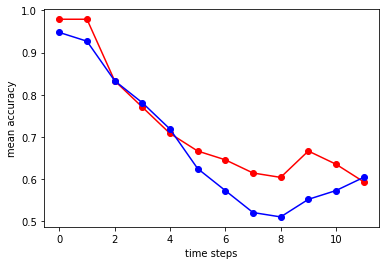

-- epoch 131 --
train loss: 0.6645121574401855
valid loss: 0.7271510362625122
-- epoch 132 --
train loss: 0.7439755797386169
valid loss: 0.8522741198539734
-- epoch 133 --
train loss: 0.6674532890319824
valid loss: 0.60703444480896
-- epoch 134 --
train loss: 0.850684642791748
valid loss: 0.8182210326194763
-- epoch 135 --
train loss: 0.7884923815727234
valid loss: 0.8231212496757507
-- epoch 136 --
train loss: 0.7489673495292664
valid loss: 0.7378185987472534
-- epoch 137 --
train loss: 0.7390072345733643
valid loss: 0.9088903665542603
-- epoch 138 --
train loss: 0.6850048303604126
valid loss: 0.8113174438476562
-- epoch 139 --
train loss: 0.6837830543518066
valid loss: 0.6403235793113708
-- epoch 140 --
train loss: 0.7066897749900818
valid loss: 0.8489505648612976


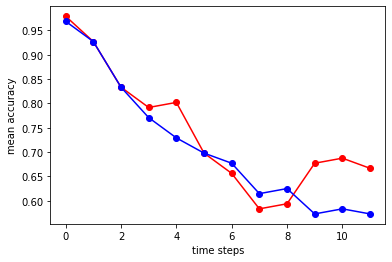

-- epoch 141 --
train loss: 0.8468901515007019
valid loss: 0.7642343044281006
-- epoch 142 --
train loss: 0.8741086721420288
valid loss: 0.8117406368255615
-- epoch 143 --
train loss: 0.684440016746521
valid loss: 0.8128951787948608
-- epoch 144 --
train loss: 0.8270847201347351
valid loss: 0.8672164678573608
-- epoch 145 --
train loss: 0.722174882888794
valid loss: 0.6494224667549133
-- epoch 146 --
train loss: 0.7689938545227051
valid loss: 0.7752591967582703
-- epoch 147 --
train loss: 0.7057051062583923
valid loss: 0.6699773073196411
-- epoch 148 --
train loss: 0.7465925216674805
valid loss: 0.8148664832115173
-- epoch 149 --
train loss: 0.826619565486908
valid loss: 0.8367443084716797
-- epoch 150 --
train loss: 0.5860410928726196
valid loss: 0.7406681776046753


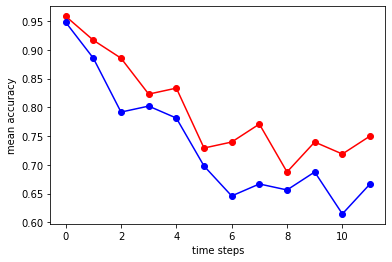

-- epoch 151 --
train loss: 0.745366096496582
valid loss: 0.7481710910797119
-- epoch 152 --
train loss: 0.8061501979827881
valid loss: 0.6843128204345703
-- epoch 153 --
train loss: 0.6792078018188477
valid loss: 0.7529962062835693
-- epoch 154 --
train loss: 0.6841615438461304
valid loss: 0.8343883752822876
-- epoch 155 --
train loss: 0.6846480369567871
valid loss: 0.9555833339691162
-- epoch 156 --
train loss: 0.7513012886047363
valid loss: 0.8779923915863037
-- epoch 157 --
train loss: 0.8053356409072876
valid loss: 0.7714145183563232
-- epoch 158 --
train loss: 0.8497457504272461
valid loss: 0.908214271068573
-- epoch 159 --
train loss: 0.8044774532318115
valid loss: 0.8828063011169434
-- epoch 160 --
train loss: 0.7617431879043579
valid loss: 0.7936028242111206


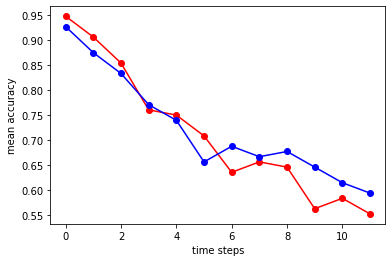

-- epoch 161 --
train loss: 0.6959227919578552
valid loss: 0.7448424696922302
-- epoch 162 --
train loss: 0.9381672143936157
valid loss: 0.9142088294029236
-- epoch 163 --
train loss: 0.6811747550964355
valid loss: 0.6938027143478394
-- epoch 164 --
train loss: 0.6817460060119629
valid loss: 0.708652138710022
-- epoch 165 --
train loss: 0.7820348739624023
valid loss: 0.7909753322601318
-- epoch 166 --
train loss: 0.8364536166191101
valid loss: 0.609519898891449
-- epoch 167 --
train loss: 0.9689689874649048
valid loss: 0.8427464962005615
-- epoch 168 --
train loss: 0.7129166126251221
valid loss: 0.6938527822494507
-- epoch 169 --
train loss: 0.6058008670806885
valid loss: 0.7011381983757019
-- epoch 170 --
train loss: 0.6752431392669678
valid loss: 0.6707441210746765


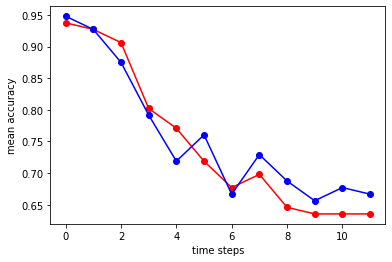

-- epoch 171 --
train loss: 0.7027010321617126
valid loss: 0.8766946196556091
-- epoch 172 --
train loss: 0.5865108966827393
valid loss: 0.8955910205841064
-- epoch 173 --
train loss: 0.884067177772522
valid loss: 0.8261472582817078
-- epoch 174 --
train loss: 0.8468772768974304
valid loss: 0.8347169756889343
-- epoch 175 --
train loss: 0.8262499570846558
valid loss: 0.8126699924468994
-- epoch 176 --
train loss: 0.7240156531333923
valid loss: 0.804124116897583
-- epoch 177 --
train loss: 0.7800523042678833
valid loss: 0.7626309394836426
-- epoch 178 --
train loss: 0.727132260799408
valid loss: 0.9122360944747925
-- epoch 179 --
train loss: 0.8519009351730347
valid loss: 0.8650049567222595
-- epoch 180 --
train loss: 0.6879156827926636
valid loss: 0.7641846537590027


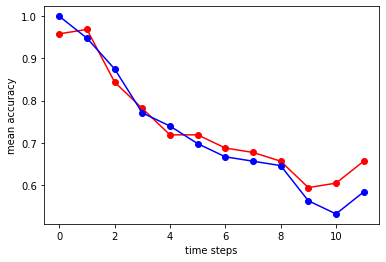

-- epoch 181 --
train loss: 0.6364223957061768
valid loss: 0.9687463641166687
-- epoch 182 --
train loss: 0.8674532175064087
valid loss: 0.7575044631958008
-- epoch 183 --
train loss: 0.7748793363571167
valid loss: 0.8038144111633301
-- epoch 184 --
train loss: 0.7417070269584656
valid loss: 0.6997537016868591
-- epoch 185 --
train loss: 0.8071727156639099
valid loss: 0.8253515958786011
-- epoch 186 --
train loss: 0.7281315326690674
valid loss: 0.7072774171829224
-- epoch 187 --
train loss: 0.9110018014907837
valid loss: 0.73338383436203
-- epoch 188 --
train loss: 0.8424397706985474
valid loss: 0.7987575531005859
-- epoch 189 --
train loss: 0.9233778715133667
valid loss: 0.6881563663482666
-- epoch 190 --
train loss: 0.7890944480895996
valid loss: 0.7865016460418701


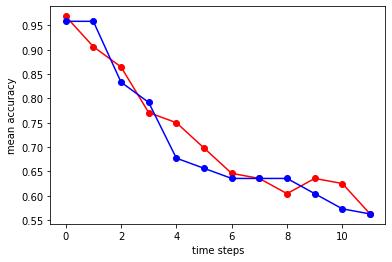

-- epoch 191 --
train loss: 0.7408499121665955
valid loss: 0.8649289608001709
-- epoch 192 --
train loss: 0.7864262461662292
valid loss: 0.7582563757896423
-- epoch 193 --
train loss: 0.7754589915275574
valid loss: 0.7246190309524536
-- epoch 194 --
train loss: 0.7590781450271606
valid loss: 0.7551325559616089
-- epoch 195 --
train loss: 0.7284444570541382
valid loss: 0.7587010264396667
-- epoch 196 --
train loss: 0.750883936882019
valid loss: 0.7640678286552429
-- epoch 197 --
train loss: 0.7265554666519165
valid loss: 0.8079623579978943
-- epoch 198 --
train loss: 0.7142402529716492
valid loss: 0.848155677318573
-- epoch 199 --
train loss: 0.6780910491943359
valid loss: 0.8097018599510193


In [23]:
for epoch in range(200):

    total_train_loss, total_train_acc = train(cpc_test, optimizer, train_dataloader, device)
    total_valid_loss, total_valid_acc = validation(cpc_test, valid_dataloader, device)
    
    print('-- epoch {0} --'.format(epoch))
    print('train loss: {0}'.format(total_train_loss))
    print('valid loss: {0}'.format(total_valid_loss))
    
    if epoch%10==0:
        plt.plot(np.mean(total_train_acc,0),'r-o')
        plt.ylabel('mean accuracy')
        plt.xlabel('time steps')

        plt.plot(np.mean(total_valid_acc,0),'b-o')
        plt.ylabel('mean accuracy')
        plt.xlabel('time steps')
    
    plt.show()

In [63]:
device

device(type='cuda')

In [27]:
# ! ls trained_models/

cpc_speech_model_2020-10-15-16:24:33 cpc_speech_model_2021-11-04-12:26:37
cpc_speech_model_2021-11-04-10:12:36 cpc_speech_opti_2020-10-15-16:24:33
cpc_speech_model_2021-11-04-11:05:00


In [25]:
ls ..

img/      notebooks/  requirements.test.txt  setup.cfg  src/   trained_models/
Makefile  README.md   requirements.txt       setup.py   test/


In [26]:
# import datetime
# save_model_folder = '../trained_models/'
# time_now = datetime.datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
# torch.save(cpc_test.state_dict(), save_model_folder+'cpc_speech_model_{0}'.format(time_now))

In [27]:
class LibriSpeech100_dataset_spk_class(Dataset):
    
    def __init__(self, data_path, seq_len, batch_size):
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.data = h5py.File(data_path, 'r')
        self.file_list = list(self.data.keys())
        self.file_list = self.file_list[:(len(self.file_list)//batch_size)*batch_size]
        
        unique_spk_ids = np.unique([f.split('-')[0] for f in list(data.keys())])
        
        self.spk_labels = {}
        for i,s_id in enumerate(unique_spk_ids):
            self.spk_labels[s_id] = i
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        filename = self.file_list[idx]
        audio_file = self.data[filename][()]
        rnd_idx = np.random.randint(0, len(audio_file)-self.seq_len)
        audio_sample = audio_file[rnd_idx:rnd_idx+self.seq_len]
        audio_sample = audio_sample.reshape(1,-1)
        
        spk_id = filename.split('-')[0]
        speaker_label = self.spk_labels[spk_id]
        
        return audio_sample, speaker_label

In [28]:
libri_train_spk = LibriSpeech100_dataset_spk_class(train_data_path,seq_len,n_samples)

NameError: name 'data' is not defined

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_dim, hidden_dim, n_labels):
        
        super(MLP, self).__init__()
        
        self.mlp = nn.Sequential(
            
            nn.Linear(input_dim,hidden_dim,bias=False),
#             nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,n_labels,bias=False)
        )
        
        def weights_initialization(module):

            if type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, 
                                        mode='fan_out', 
                                        nonlinearity='relu')
        
        self.log_softmax =nn.LogSoftmax(dim=-1)
        
        self.apply(weights_initialization)
        
        
        
    def forward(self,X):
        
        y = self.mlp(X)
#         y = self.log_softmax(y)
        
        return y

In [ ]:
mlp = MLP(256,512,10)

In [18]:
 2e-4

0.0002

In [32]:
data = h5py.File(train_output_path, 'r')
data_keys = list(data.keys())

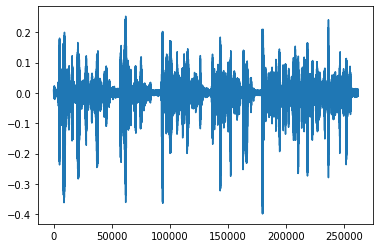

In [39]:
plt.plot(data[data_keys[0]][()])

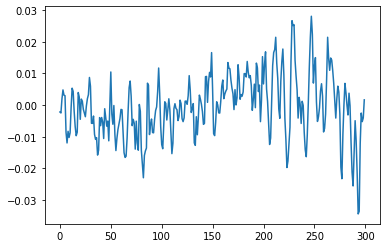

In [50]:
plt.plot(libri_train.__getitem__(0).squeeze()[:300])

In [51]:
for idx_batch, batch in enumerate(train_dataloader):
    
    print(batch.shape)
    
    break

torch.Size([8, 1, 20480])


In [103]:
cpc_test = CPC(n_timesteps, n_samples, seq_len).to(device)

In [104]:
hidden = cpc_test.initialize_hidden(gpu=gpu)
loss, acc, hidden, f_k = cpc_test.forward(batch.float().to(device),hidden)

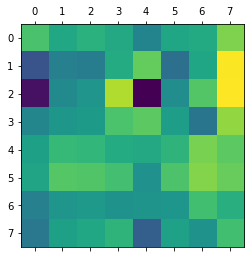

In [105]:
plt.matshow(f_k.detach().numpy())

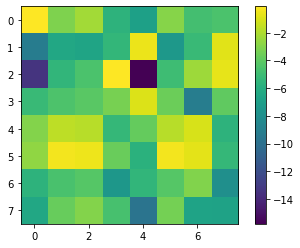

In [106]:
plt.imshow(cpc_test.log_softmax(f_k).detach().numpy())
plt.colorbar()

In [50]:
conv1d = nn.Conv1d(10, 512, stride=5, kernel_size=10, padding=3, bias=False)

In [51]:
X = torch.randn(2,10,100)

conv1d(X).shape

torch.Size([2, 512, 20])

In [49]:
X

tensor([[[ 2.6343e-01,  5.1540e-02,  4.4251e-01, -1.1553e-01, -8.7427e-01,
           1.0815e+00,  3.9670e-02, -1.1815e+00, -1.1697e+00,  9.6030e-01,
          -1.9666e-01,  2.5315e+00, -5.8794e-01,  8.4098e-02, -2.0362e+00,
           6.7987e-01, -7.4947e-01,  3.1108e-01, -8.5376e-01, -9.3215e-01,
          -6.0026e-02, -1.9264e+00,  1.3246e-01,  1.7619e+00,  3.9367e-01,
          -1.9350e+00, -1.6398e+00,  1.7292e+00,  1.8188e+00, -3.0045e+00,
           8.6752e-01,  2.5459e-01,  7.2609e-01,  1.0013e+00,  1.5233e-01,
          -1.6577e-01,  1.0799e+00, -1.8680e+00,  1.1837e-01,  3.9662e-02,
          -4.9171e-01,  1.0302e+00,  1.2931e+00,  7.1948e-01,  9.6432e-01,
          -3.7818e-02,  2.2440e-01, -9.5198e-01,  2.5050e-01, -1.0614e-02,
          -1.7795e+00, -8.4948e-02,  8.0950e-02,  2.3937e+00, -5.9314e-01,
          -9.2215e-02, -1.7215e+00,  1.1601e-01, -1.1146e+00,  1.8830e+00,
           4.4913e-01,  9.3437e-01, -5.1901e-01,  1.5660e+00, -9.1825e-02,
           2.7783e-02,  1